## 1. Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Listing current data on our folder.
import os
print(os.listdir("."))

['generated', 'MidiCollection', '.DS_Store', 'sequence_examples', 'Untitled.ipynb', 'README.md', 'notesequences.tfrecord', 'run_dir', '.ipynb_checkpoints', '.git', 'MidiFeatureExtraction.ipynb']


In [2]:
#!pip install music21

In [3]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

## 2. Opening a Sample Midi File - MidiCollection/0/070102 (I\'ll Love You Always).MID

In [4]:
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi('MidiCollection/0/070102 (I\'ll Love You Always).MID', False)
base_midi

<music21.stream.Score 0xa22e01908>

## 3. Listing Instruments in the sample Midi

In [5]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Soprano Saxophone
Saxophone
Tenor Saxophone
Baritone Saxophone
Piano
None
StringInstrument
Guitar
Acoustic Bass
Piano


## 4.plot with notes

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))


<Figure size 1200x500 with 1 Axes>

## 5. Pitch Histogram - might be a good way to guess the music keys

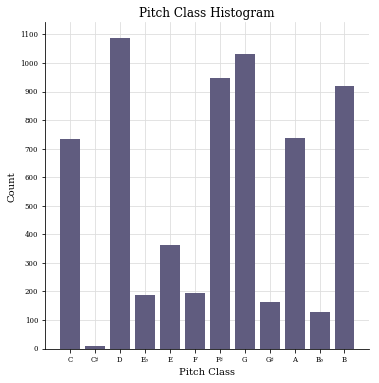

In [7]:
base_midi.plot('histogram', 'pitchClass', 'count')


## 6. Scatter Plot - not sure what it shows. 

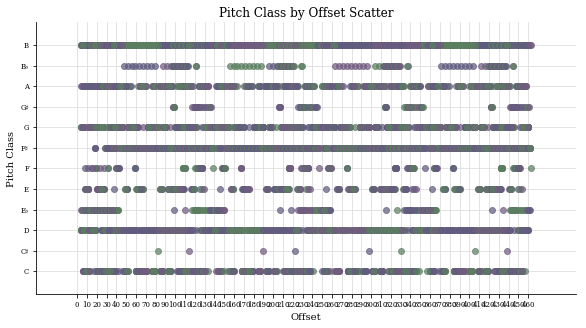

In [8]:
base_midi.plot('scatter', 'offset', 'pitchClass')


## 7.Composition Parameters

In [9]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: G major
Music key confidence: 0.9366364881102435
Other music key alternatives:
e minor
C major
a minor
D major


## 8. Harmonic Sequence Analyzing - very helpful when we want to compare it with similar music later in the notebook

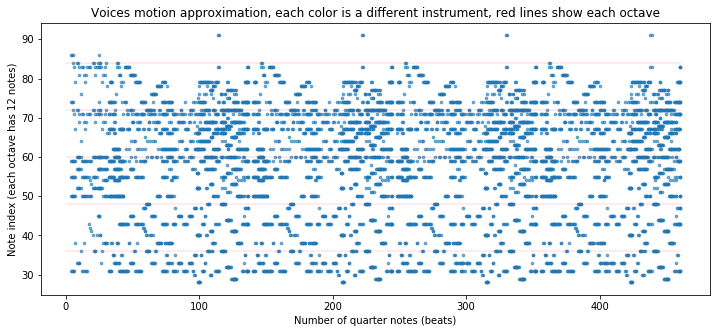

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=100.0>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest rest>
    {1.0} <music21.instrument.SopranoSaxophone Soprano Saxophone>


In [10]:
from music21 import stream

temp_midi_chords = open_midi(
   'MidiCollection/0/070102 (I\'ll Love You Always).MID',
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")

## 9. Trying to find the chords - this is confusing to me right now

In [11]:
from music21 import roman

def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note

def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret


def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret
harmonic_reduction(base_midi)[0:10]


['-', '-VI42', 'ii', '-VI42', '-vi42', 'iv', 'ii', 'vii42', '-VI53', 'V65']

### The previous harmonic reduction looks pretty confusing, maybe the melodic lines include several nonchord notes which changes the Chord Quality. If we get a music like Bach's Prelude in C-major which uses a lot of chord arpeggios, we can see that our function works pretty well. At least on the beginning it gets almost all correct chords and other with minor errors.

In [12]:
from music21 import corpus

bachChorale = corpus.parse('bach/bwv846')
harmonic_reduction(bachChorale)[0:11]

['I', 'ii42', 'vii53', 'I', 'vi6', 'ii42', 'V6', 'i42', 'vi7', 'II7', 'V']

## 10. Converting all information to a pandas dataframe

In [ ]:
from multiprocessing import Pool

def get_file_name(link):
    filename = link.split('/')[::-1][0]
    return filename

def concat_path(path, child):
    return path + "/" + child


def process_single_file(midi_param):
    try:
        midi_path = midi_param
        print(midi_path)
        midi_name = get_file_name(midi_path)
        midi = open_midi(midi_path, True)
        return (
            midi.analyze('key'),
            harmonic_reduction(midi),
            midi_name)
    except Exception as e:
        print("Error on {0}".format(midi_name))
        print(e)
        return None
    
def create_midi_dataframe(folderPath):
    key_signature_column = []
    harmonic_reduction_column = []
    midi_name_column = []
    pool = Pool(8)
    midi_params = []        
    for midi_name in os.listdir(folderPath):
            midi_params.append(concat_path(folderPath, midi_name))

    results = pool.map(process_single_file, midi_params)
    for result in results:
        if (result is None):
            continue
            
        key_signature_column.append(result[0])
        harmonic_reduction_column.append(result[1])
        midi_name_column.append(result[2])
        
    d = {'midi_name': midi_name_column,
         'key_signature' : key_signature_column,
         'harmonic_reduction': harmonic_reduction_column}
    return pd.DataFrame(data=d)

midi_folder_path = 'MidiCollection/0/'
sonic_df = create_midi_dataframe(midi_folder_path)

MidiCollection/0//070527 (Oh for a Poet).MID
MidiCollection/0//070110 (The Raven Days).MID
MidiCollection/0//.DS_Store
MidiCollection/0//070606 (Hail the Comic Song).MID
MidiCollection/0//Celine Dion - Fly 2.mid
MidiCollection/0//070102 (I'll Love You Always).MID
MidiCollection/0//040_-_Ibiza_Dreams__J.D._20110615094526.mid
MidiCollection/0//051230.MID
Error on .DS_Store
badly formated midi bytes, got: b'\x00\x00\x00\x01Bud1\x00\x00\x10\x00\x00\x00\x08\x00\x00\x00\x10\x00'
MidiCollection/0//050620B (The Children of the Night).MID
Error on 040_-_Ibiza_Dreams__J.D._20110615094526.mid
cannot place element  with start/end 96.0/96.0 within any measures
MidiCollection/0//009count.mid


In [ ]:
sonic_df

### Since the harmonic sequences are just a list of strings, we could handle it as a common sentence from a text document. Lets try to use word2vec (more here) to find some relationships between chords on Sonic games compositions.

In [ ]:
# import modules & set up logging
import gensim, logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
model = gensim.models.Word2Vec(sonic_df["harmonic_reduction"], min_count=2, window=4)

## 11. Similarity between MIDIs

In [ ]:
import pprint
def vectorize_harmony(model, harmonic_reduction):
    # Gets the model vector values for each chord from the reduction.
    word_vecs = []
    for word in harmonic_reduction:
        try:
            vec = model[word]
            word_vecs.append(vec)
        except KeyError:
            # Ignore, if the word doesn't exist in the vocabulary
            pass
    
    # Assuming that document vector is the mean of all the word vectors.
    return np.mean(word_vecs, axis=0)

def cosine_similarity(vecA, vecB):
    # Find the similarity between two vectors based on the dot product.
    csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
    if np.isnan(np.sum(csim)):
        return 0
    
    return csim

In [ ]:
def calculate_similarity_aux(df, model, source_name, target_names=[], threshold=0):
    source_harmo = df[df["midi_name"] == source_name]["harmonic_reduction"].values[0]
    source_vec = vectorize_harmony(model, source_harmo)    
    results = []
    for name in target_names:
        target_harmo = df[df["midi_name"] == name]["harmonic_reduction"].values[0]
        if (len(target_harmo) == 0):
            continue
            
        target_vec = vectorize_harmony(model, target_harmo)       
        sim_score = cosine_similarity(source_vec, target_vec)
        if sim_score > threshold:
            results.append({
                'score' : sim_score,
                'name' : name
            })
                
    # Sort results by score in desc order
    results.sort(key=lambda k : k['score'] , reverse=True)
    return results

In [ ]:
def calculate_similarity(df, model, source_name, threshold=0):
    source_midi_names = df[df["midi_name"] == source_name]["midi_name"].values
    if (len(source_midi_names) == 0):
        print("Invalid source name")
        return
    
    source_midi_name = source_midi_names[0]
    
    target_midi_names = df["midi_name"].values  
    if (len(target_midi_names) == 0):
        print("Invalid target prefix")
        return
    
    return calculate_similarity_aux(df, model, source_midi_name, target_midi_names, threshold)


In [ ]:
pp = pprint.PrettyPrinter(width=41, compact=True)
pp.pprint(calculate_similarity(sonic_df, model, "070102 (I'll Love You Always).MID")) # comparing all the other midis with this